<a href="https://colab.research.google.com/github/AYALDAH/airtrafic/blob/main/Pr%C3%A9vision_du_Traffic_A%C3%A9rien.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Analyse traffic dataset ✈
## Auteure : AYI KPADONOU Aldah
## Dans cette annalyse nous présenterons principalement les points suivants:
- Affichage des données d'une route sous forme d'un graphique plotly
- Entrainement d’un modèle Prophet pour une route donnée avec une prévision de x 
jours

In [ ]:
#Install pandas profiling
!pip install --upgrade pandas-profiling

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#Importation des packages
import pandas as pd
from pandas_profiling import ProfileReport
import datetime
import plotly
import pandas as pd
import seaborn as sns
import plotly.offline as pyoff
import plotly.graph_objs as go
from plotly.subplots import make_subplots
from prophet import Prophet
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
from prophet.plot import plot_cross_validation_metric
import logging
from asyncio import run_coroutine_threadsafe
from prophet.serialize import model_to_json, model_from_json
from joblib import  dump, load

In [ ]:
#Importation de la base de données
Traffic_df=pd.read_parquet('traffic_10lines.parquet')

In [ ]:
#Informations sur la base de données
Traffic_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 254899 entries, 3223247 to 10014282
Data columns (total 21 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   date                254899 non-null  datetime64[ns]
 1   pax                 254899 non-null  float64       
 2   seats               250749 non-null  float64       
 3   flight_type         251168 non-null  object        
 4   flight_typename     254899 non-null  object        
 5   home_airport        254899 non-null  object        
 6   paired_airport      254899 non-null  object        
 7   home_airportname    254899 non-null  object        
 8   paired_airportname  254899 non-null  object        
 9   distance            254899 non-null  Int64         
 10  flight_number       251438 non-null  object        
 11  airline_iata        248648 non-null  object        
 12  airline_name        254813 non-null  object        
 13  scheduled_datetime  2

Notre Base de données contient 21 variables avec 254899 observations. Les donnés s'étendent du 01/01/2016 au 10/03/2023

Dans le but de présenter les données en détail, nous allons effectuer un pandas profiling

In [ ]:
Data_profile_report = ProfileReport(Traffic_df)
Data_profile_report.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Le profil des données ci-dessus représenté nous permet d'explorer nos données de manière exhaustive. Ce profilage nous permet d'avoir une vue d'ensemble sur les données mais également des information par variable, les correlations entre les variables et les interractions. Dans la vue d'ensemble et sur le détail des variables nous pouvons déja remarqué les valeurs manquantes ainsi que leurs pourcentages.

Affichons la table contenant le nombre total de passagers par route et par direction

In [ ]:
(Traffic_df
.groupby(['home_airport','paired_airport','direction'])
.agg(date_min=('date','min'),date_max=('date','max'),pax=('pax','sum'))
.reset_index()
 )

,home_airport,paired_airport,direction,date_min,date_max,pax
0,LGW,AMS,A,2016-01-01,2023-03-09,2686346.0
1,LGW,AMS,D,2016-01-01,2023-03-09,2686476.0
2,LGW,BCN,A,2016-01-01,2023-03-10,3813240.0
3,LGW,BCN,D,2016-01-01,2023-03-09,3799836.0
4,LIS,OPO,A,2016-01-01,2023-03-09,2819094.0
5,LIS,OPO,D,2016-01-01,2023-03-09,2813651.0
6,LIS,ORY,A,2016-01-01,2023-03-09,3835664.0
7,LIS,ORY,D,2016-01-01,2023-03-09,3860404.0
8,LYS,PIS,A,2017-11-20,2023-03-09,6173.0
9,LYS,PIS,D,2018-01-02,2023-03-09,4178.0


Affichons le tableau présentant le nombre de passagers sur la route NTE -FUE

In [ ]:
nte_fue= (Traffic_df
     .query('home_airport == "NTE" and paired_airport == "FUE"')
     .groupby(['home_airport', 'paired_airport', 'date'])
     .agg(pax_total=('pax', 'sum'))
     .reset_index()
    )
nte_fue

,home_airport,paired_airport,date,pax_total
0,NTE,FUE,2019-01-06,456.0
1,NTE,FUE,2019-01-07,142.0
2,NTE,FUE,2019-01-13,519.0
3,NTE,FUE,2019-01-20,553.0
4,NTE,FUE,2019-01-27,528.0
...,...,...,...,...
288,NTE,FUE,2023-02-19,296.0
289,NTE,FUE,2023-02-25,638.0
290,NTE,FUE,2023-02-26,289.0
291,NTE,FUE,2023-03-04,584.0


## Affichage des données d’une route (homeAirport – pairedAirport) sous forme d’un graphique Plotly

In [ ]:
#Nous définissons la fonction permettant d'aafficher les données d'une route en format plotly
def draw_ts_multiple(df: pd.DataFrame, v1: str, v2: str=None, prediction: str=None, date: str='date',
              secondary_y=True, covid_zone=False, display=True):
  """Draw times series possibly on two y axis, with COVID period option.

  Args:
  - df (pd.DataFrame): time series dataframe (one line per date, series in columns)
  - v1 (str | list[str]): name or list of names of the series to plot on the first x axis
  - v2 (str): name of the serie to plot on the second y axis (default: None)
  - prediction (str): name of v1 hat (prediction) displayed with a dotted line (default: None)
  - date (str): name of date column for time (default: 'date')
  - secondary_y (bool): use a secondary y axis if v2 is used (default: True)
  - covid_zone (bool): highlight COVID-19 period with a grayed rectangle (default: False)
  - display (bool): display figure otherwise just return the figure (default: True)

  Returns:
  - fig (plotly.graph_objs._figure.Figure): Plotly figure generated

  Notes:
  Make sure to use the semi-colon trick if you don't want to have the figure displayed twice.
  Or use `display=False`.
  """
  if isinstance(v1, str):
    variables = [(v1, 'V1')]
  else:
    variables = [(v, 'V1.{}'.format(i)) for i, v in enumerate(v1)]
  title = '<br>'.join([n + ': '+ v for v, n in variables]) + ('<br>V2: ' + v2) if v2 else '<br>'.join([v + ': '+ n for v, n in variables])
  layout = dict(
    title=title,
    xaxis=dict(
        rangeselector=dict(
            buttons=list([
                dict(count=1,
                     label='1m',
                     step='month',
                     stepmode='backward'),
                dict(count=6,
                     label='6m',
                     step='month',
                     stepmode='backward'),
                dict(step='all')
            ])
        ),
        rangeslider=dict(
            visible = True
        ),
        type='date'
    )
  )
  fig = make_subplots(specs=[[{"secondary_y": True}]])
  fig.update_layout(layout)
  for v, name in variables:
    fig.add_trace(go.Scatter(x=df[date], y=df[v], name=name), secondary_y=False)
  if v2:
    fig.add_trace(go.Scatter(x=df[date], y=df[v2], name='V2'), secondary_y=secondary_y)
    fig['layout']['yaxis2']['showgrid'] = False
    fig.update_yaxes(rangemode='tozero')
    fig.update_layout(margin=dict(t=125 + 30 * (len(variables) - 1)))
  if prediction:
    fig.add_trace(go.Scatter(x=df[date], y=df[prediction], name='^V1', line={'dash': 'dot'}), secondary_y=False)

  if covid_zone:
    fig.add_vrect(
        x0=pd.Timestamp("2020-03-01"), x1=pd.Timestamp("2022-01-01"),
        fillcolor="Gray", opacity=0.5,
        layer="below", line_width=0,
    )
  if display:
    pyoff.iplot(fig)
  return fig

Representation sous forme plotly des passagers sur la route NTE-FUE

In [ ]:
draw_ts_multiple(
    (Traffic_df
     .query('home_airport == "NTE" and paired_airport == "FUE"')
     .groupby(['home_airport', 'paired_airport', 'date'])
     .agg(pax_total=('pax', 'sum'))
     .reset_index()
    ),
    'pax_total',
    covid_zone=True
)

Interpretation : Le graphique nous permet de voir que de Janvier 2020 à Juillet 2021, des périodes marqués par la covid-19, une baisse considérable du nombre de passager sur la route NTE-FUE dû au confinement et à la fermeture des frontières. A partir du mois de janvier,une reprise progressive de l'activité se remarque.

## Entrainement d’un modèle Prophet pour une route donnée avec une prévision de x jours
Nous utiliserons ici la route NTE-FUE

Création d'une fonction permettant de générer uen table de donnée du nombre total de passager suivant une route donnée. Ainsi pour avoir une table avec différentes routes on changera les paramètres de la fonction en indiquant la route désirée.

In [ ]:
#Fonction de création de la dataframe
def generate_route_df(traffic_df:pd.DataFrame,homeAirport:str, pairedAirport:str)-> pd.DataFrame:
  """Extract route dataframe from dataframe for route from home airport to paired airport
  Args:
  -traffic_df(pd.DataFrame):traffic dataframe
  -homeAirport(str):IATA Code for home airport
  -pairedAirport(str):IATA Code for paired airport 

  Returns:
  -pd.DataFrame: aggregated daily PAX traffic on route (home-paired)"""
  _df=(Traffic_df
       .query('home_airport=="{home}" and paired_airport=="{paired}"'.format(home=homeAirport,paired=pairedAirport))
       .groupby(['home_airport','paired_airport','date'])
       .agg(pax_total=('pax','sum'))
       .reset_index()
       )
  return _df
  #Affichons le tableau pour la route NTE-FUE
generate_route_df(Traffic_df,"NTE","FUE")

,home_airport,paired_airport,date,pax_total
0,NTE,FUE,2019-01-06,456.0
1,NTE,FUE,2019-01-07,142.0
2,NTE,FUE,2019-01-13,519.0
3,NTE,FUE,2019-01-20,553.0
4,NTE,FUE,2019-01-27,528.0
...,...,...,...,...
288,NTE,FUE,2023-02-19,296.0
289,NTE,FUE,2023-02-25,638.0
290,NTE,FUE,2023-02-26,289.0
291,NTE,FUE,2023-03-04,584.0


Model Prophet pour la route NTE-FUE

In [ ]:
#Mise en place du model pour la route NTE-FUE
baseline_model=Prophet()
baseline_model.fit(generate_route_df(Traffic_df, "NTE","FUE").rename(columns={'date':'ds','pax_total':'y'}))

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp26haa21q/n2tq7yue.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp26haa21q/322l9s_6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=66295', 'data', 'file=/tmp/tmp26haa21q/n2tq7yue.json', 'init=/tmp/tmp26haa21q/322l9s_6.json', 'output', 'file=/tmp/tmp26haa21q/prophet_model0zmyk8fr/prophet_model-20230528230136.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:01:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
23:01:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [ ]:
#Definissons une  période future de  15 jours : complémentaire aux donnée existantes 
future_df=baseline_model.make_future_dataframe(periods=15)# prepare to predict 15 days
future_df

,ds
0,2019-01-06
1,2019-01-07
2,2019-01-13
3,2019-01-20
4,2019-01-27
...,...
303,2023-03-16
304,2023-03-17
305,2023-03-18
306,2023-03-19


In [ ]:
#Faisons l'entrainement du modele avec une vision de 15 jours
forecast_df=baseline_model.predict(future_df)
forecast_df

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2019-01-06,366.987264,328.414204,628.690721,366.987264,366.987264,113.963365,113.963365,113.963365,136.806409,136.806409,136.806409,-22.843043,-22.843043,-22.843043,0.0,0.0,0.0,480.950629
1,2019-01-07,366.754933,60.998743,372.557786,366.754933,366.754933,-148.140453,-148.140453,-148.140453,-115.899406,-115.899406,-115.899406,-32.241047,-32.241047,-32.241047,0.0,0.0,0.0,218.614479
2,2019-01-13,365.360946,271.236966,579.490733,365.360946,365.360946,56.838713,56.838713,56.838713,136.806409,136.806409,136.806409,-79.967696,-79.967696,-79.967696,0.0,0.0,0.0,422.199658
3,2019-01-20,363.734627,263.227757,563.830044,363.734627,363.734627,49.792236,49.792236,49.792236,136.806409,136.806409,136.806409,-87.014173,-87.014173,-87.014173,0.0,0.0,0.0,413.526863
4,2019-01-27,362.108309,314.328484,623.650925,362.108309,362.108309,103.916880,103.916880,103.916880,136.806409,136.806409,136.806409,-32.889528,-32.889528,-32.889528,0.0,0.0,0.0,466.025189
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
303,2023-03-16,250.086252,-33.745012,265.265857,250.086252,250.086252,-132.497205,-132.497205,-132.497205,-256.348557,-256.348557,-256.348557,123.851352,123.851352,123.851352,0.0,0.0,0.0,117.589047
304,2023-03-17,250.129075,251.681019,579.928585,250.129075,250.129075,168.375159,168.375159,168.375159,44.060402,44.060402,44.060402,124.314757,124.314757,124.314757,0.0,0.0,0.0,418.504234
305,2023-03-18,250.171898,328.470637,607.367123,250.171898,250.173411,227.954512,227.954512,227.954512,103.260604,103.260604,103.260604,124.693908,124.693908,124.693908,0.0,0.0,0.0,478.126410
306,2023-03-19,250.214721,354.408273,660.108030,250.214344,250.218145,261.821769,261.821769,261.821769,136.806409,136.806409,136.806409,125.015360,125.015360,125.015360,0.0,0.0,0.0,512.036491


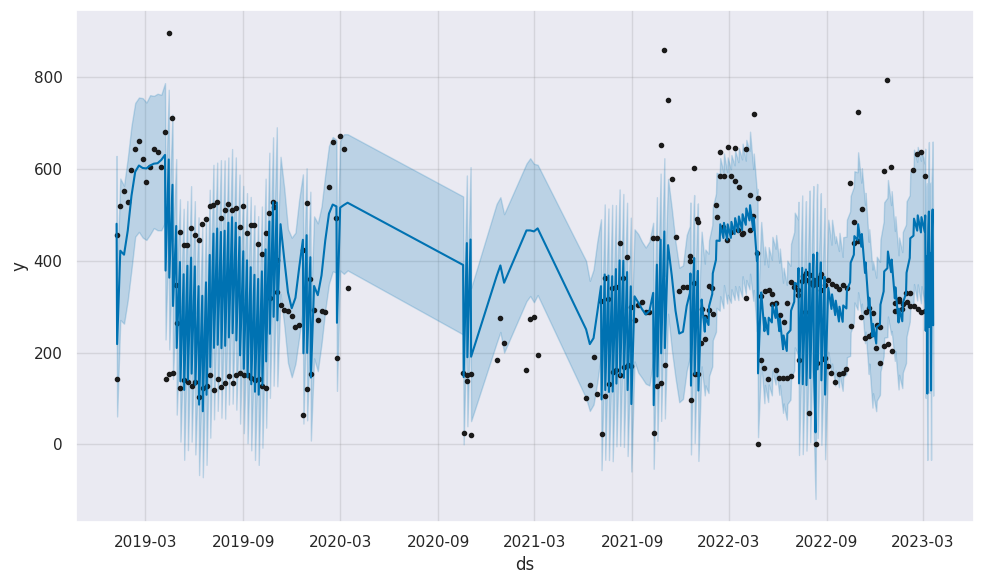

In [ ]:
#Représentation graphique des résultats 
sns.set()
baseline_model.plot(forecast_df);

En analysant ce graphique nous remarquons que les plus fortes baisses du nombre de passagers sur la route NTE-FUE ont lieu entre Mars 2020-Septembre 2020  et entre Mars 2021 et Septembre 2021.

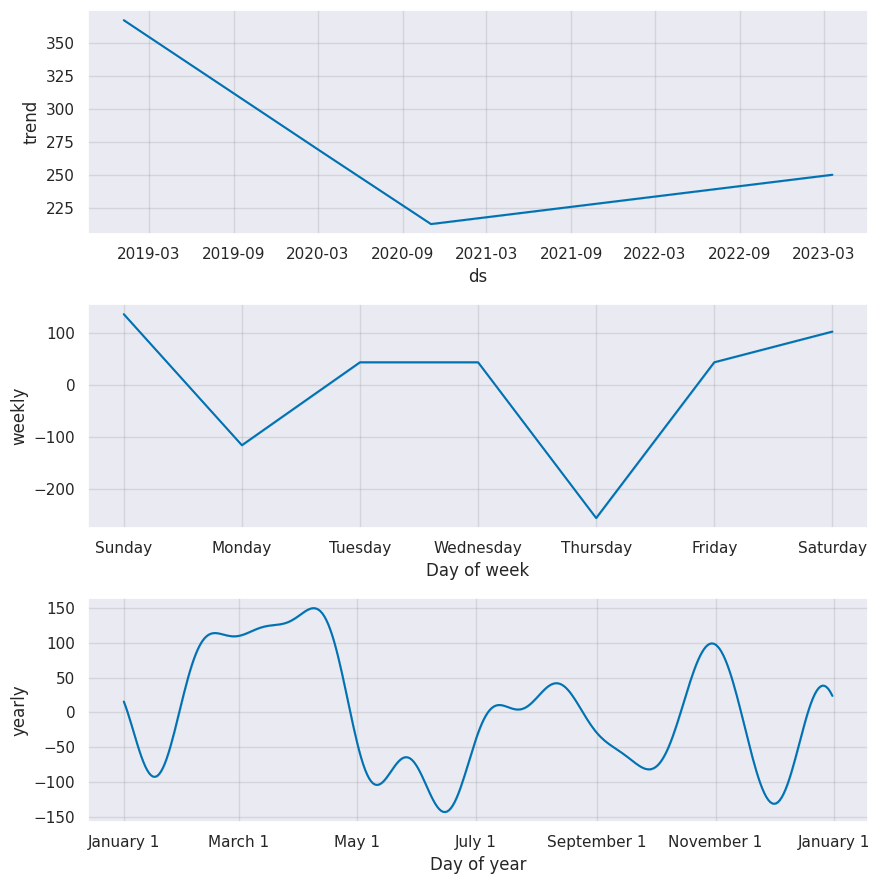

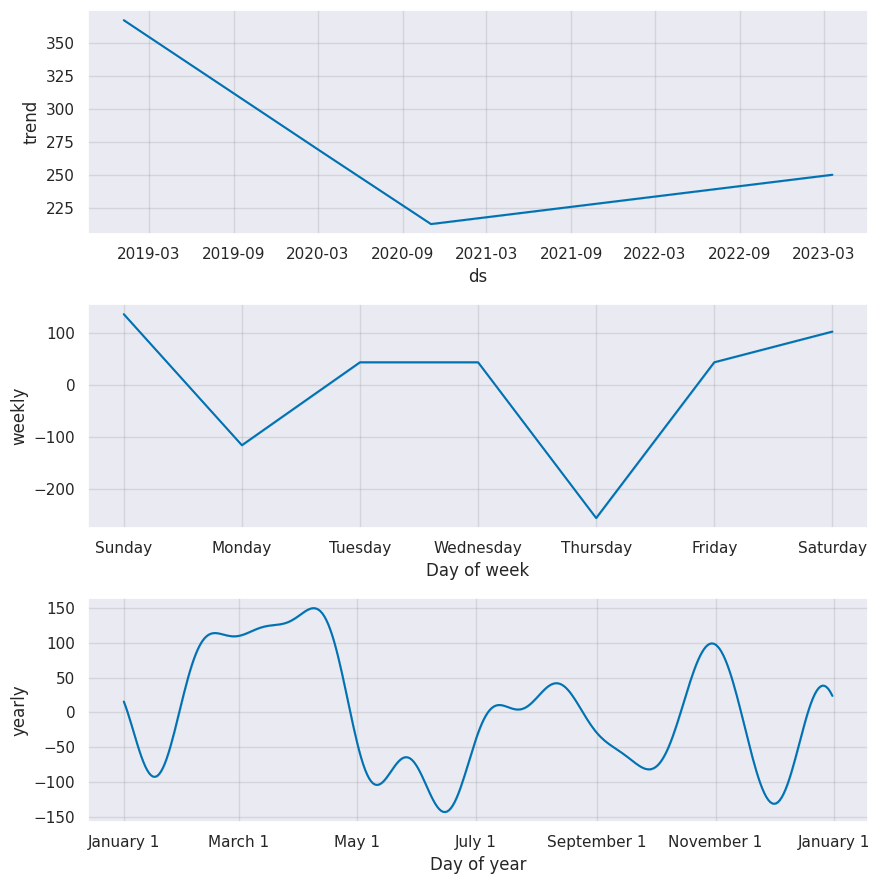

In [ ]:
#Represntons graphiquement les élements issus de l'entrainement.
baseline_model.plot_components(forecast_df)

On peut remarquer que selon la prédiction, sur le graphique "trend", les plus faibles nombre de passagers seront enrégistrés entre septembre 2020 et Janvier 2021. Aussi les mardi et jeudi sont des jour avec le moins de passager sur cette route

Evaluer les  performances du model PROPHET(RMSE ou MAPE)

In [ ]:
#Evaluons les performance des prédictions du modèle PROPHETE
evaluation_df=cross_validation(baseline_model,period='90 days', horizon='90 days')

INFO:prophet:Making 10 forecasts with cutoffs between 2020-09-16 00:00:00 and 2022-12-05 00:00:00


  0%|          | 0/10 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp26haa21q/vs3e70kv.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp26haa21q/0ta46su6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=7357', 'data', 'file=/tmp/tmp26haa21q/vs3e70kv.json', 'init=/tmp/tmp26haa21q/0ta46su6.json', 'output', 'file=/tmp/tmp26haa21q/prophet_modelrd9k6j1w/prophet_model-20230528230139.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
23:01:39 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
23:01:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp26haa21q/dxkh0ees.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp26haa21q/qx4sp5hx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

In [ ]:
#DataFrame des variables prédites après la cross validation
evaluation_df

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2020-10-18,447.472952,357.504136,545.544842,155.0,2020-09-16
1,2020-10-19,124.280990,35.232319,220.478878,26.0,2020-09-16
2,2020-10-25,488.585274,394.351923,580.196078,152.0,2020-09-16
3,2020-10-26,153.801841,69.293084,252.078610,139.0,2020-09-16
4,2020-11-01,439.584883,342.607478,538.417301,20.0,2020-09-16
...,...,...,...,...,...,...
189,2023-02-19,562.993455,421.175234,702.985370,296.0,2022-12-05
190,2023-02-25,465.255019,329.394423,614.362812,638.0,2022-12-05
191,2023-02-26,553.509927,415.593961,690.972467,289.0,2022-12-05
192,2023-03-04,465.385062,321.333460,596.870451,584.0,2022-12-05


In [ ]:
#Les métrics permattant d'évaluer la performance du model
performance_metrics(evaluation_df)

INFO:prophet:Skipping MAPE because y close to 0


,horizon,mse,rmse,mae,mdape,smape,coverage
0,10 days,7964.572025,89.244451,72.291339,0.209460,0.282279,0.736842
1,11 days,9346.762087,96.678654,78.280908,0.227023,0.317436,0.710526
2,12 days,12625.430698,112.362942,86.326633,0.209460,0.325730,0.684211
3,13 days,13687.832616,116.995011,90.400662,0.229651,0.334530,0.657895
4,14 days,12874.968302,113.467918,85.317102,0.192882,0.318882,0.684211
...,...,...,...,...,...,...,...
76,86 days,35044.098263,187.200690,154.016154,0.566636,0.616390,0.403509
77,87 days,31087.535293,176.316577,150.802874,0.497562,0.555897,0.368421
78,88 days,28591.350991,169.089772,142.621852,0.445899,0.528505,0.368421
79,89 days,24919.942869,157.860517,131.487817,0.388496,0.490253,0.473684


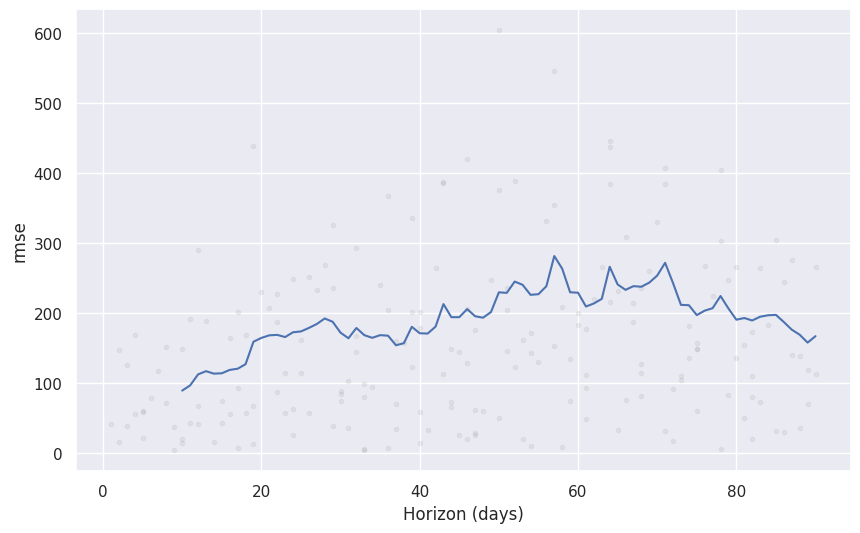

In [ ]:
#Représentation graphique du RMSE
plot_cross_validation_metric(evaluation_df,metric='rmse');

En analysant le tableau des métrics et le graphique du RMSE, on pourrait conclure que le modèle donne de meilleures résultat à l'horizon de 10 jours

## Géneralisation du moele prophete à plusieurs routes

In [ ]:
# Automatisation du moedel pour les differentes routes

In [ ]:
#Créons une table qui répertorie  les valeurs uniques  des routes existantes dans notre base
routes=(Traffic_df
.drop_duplicates(subset=['home_airport','paired_airport'])
[['home_airport','paired_airport']]
.to_dict(orient='rows')
)
routes

<ipython-input-40-ab8b15c642c8>:2: FutureWarning:

Using short name for 'orient' is deprecated. Only the options: ('dict', list, 'series', 'split', 'records', 'index') will be used in a future version. Use one of the above to silence this warning.



[{'home_airport': 'LGW', 'paired_airport': 'BCN'},
 {'home_airport': 'LGW', 'paired_airport': 'AMS'},
 {'home_airport': 'LIS', 'paired_airport': 'ORY'},
 {'home_airport': 'LIS', 'paired_airport': 'OPO'},
 {'home_airport': 'SSA', 'paired_airport': 'GRU'},
 {'home_airport': 'NTE', 'paired_airport': 'FUE'},
 {'home_airport': 'LYS', 'paired_airport': 'PIS'},
 {'home_airport': 'PNH', 'paired_airport': 'NGB'},
 {'home_airport': 'POP', 'paired_airport': 'JFK'},
 {'home_airport': 'SCL', 'paired_airport': 'LHR'}]

In [ ]:
#Généralisation du modèle Prophet à toutes les routes et évaluation des perfomances pour chaque route.La boucle suivante nous permet de réaliser cette généralisation.

models=dict()
performances=dict()

for route in routes:
  print(route)
  home=route['home_airport']
  paired=route['paired_airport']
  #print(home, paired

  #Build route traffic dataframe
  _df=generate_route_df(Traffic_df,home, paired)

  #create a model
  _model=Prophet()

  #fit & evaluate the model
  _model.fit(_df.rename(columns={'date':'ds','pax_total':'y'}))

  #Cross validation the model
  _cv_df=cross_validation(_model,horizon='90 days',parallel="processes")
  _perf_df=performance_metrics(_cv_df,rolling_window=1)

  #Save the model to a dictionary
  models[(route['home_airport'], route['paired_airport'])]=_model
  performances[(route['home_airport'],route['paired_airport'])]=_perf_df['rmse'].values[0]

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp26haa21q/9yc3xn5s.json


{'home_airport': 'LGW', 'paired_airport': 'BCN'}


DEBUG:cmdstanpy:input tempfile: /tmp/tmp26haa21q/_7wq_i5a.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=61408', 'data', 'file=/tmp/tmp26haa21q/9yc3xn5s.json', 'init=/tmp/tmp26haa21q/_7wq_i5a.json', 'output', 'file=/tmp/tmp26haa21q/prophet_modelqbaubcbo/prophet_model-20230528230142.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:01:42 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
23:01:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 49 forecasts with cutoffs between 2017-01-10 00:00:00 and 2022-12-10 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fb5d777e140>
DEBUG:cmdstanpy:input tempfile: /tmp/tmp26haa21q/re4dhjkm.json
DEBUG:cmdstanpy:input tempfile:

{'home_airport': 'LGW', 'paired_airport': 'AMS'}


23:02:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 49 forecasts with cutoffs between 2017-01-09 00:00:00 and 2022-12-09 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fb5d99302b0>
DEBUG:cmdstanpy:input tempfile: /tmp/tmp26haa21q/9irr91e1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp26haa21q/wvj74c8f.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp26haa21q/opy9vsbo.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=18398', 'data', 'file=/tmp/tmp26haa21q/9irr91e1.json', 'init=/tmp/tmp26haa21q/opy9vsbo.json', 'output', 'file=/tmp/tmp26haa21q/prophet_models19ujvnw/prophet_model-20230528230207.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
DEBUG:cmdstanpy:input tempfile: /tmp/tmp26haa21q/tdx4aqke.json
DEBU

{'home_airport': 'LIS', 'paired_airport': 'ORY'}


DEBUG:cmdstanpy:input tempfile: /tmp/tmp26haa21q/7k8xb4xv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=575', 'data', 'file=/tmp/tmp26haa21q/nnlt4lpi.json', 'init=/tmp/tmp26haa21q/7k8xb4xv.json', 'output', 'file=/tmp/tmp26haa21q/prophet_modelkgu_t3j_/prophet_model-20230528230226.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:02:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
23:02:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 49 forecasts with cutoffs between 2017-01-09 00:00:00 and 2022-12-09 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fb5d9a93160>
DEBUG:cmdstanpy:input tempfile: /tmp/tmp26haa21q/n1fmxuhm.json
DEBUG:cmdstanpy:input tempfile: /

{'home_airport': 'LIS', 'paired_airport': 'OPO'}


DEBUG:cmdstanpy:input tempfile: /tmp/tmp26haa21q/_jt5f6lh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=75614', 'data', 'file=/tmp/tmp26haa21q/oi1bnxn1.json', 'init=/tmp/tmp26haa21q/_jt5f6lh.json', 'output', 'file=/tmp/tmp26haa21q/prophet_modelawsue45r/prophet_model-20230528230251.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:02:51 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
23:02:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 49 forecasts with cutoffs between 2017-01-09 00:00:00 and 2022-12-09 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fb6505cb400>
DEBUG:cmdstanpy:input tempfile: /tmp/tmp26haa21q/1e6h27vl.json
DEBUG:cmdstanpy:input tempfile:

{'home_airport': 'SSA', 'paired_airport': 'GRU'}


23:03:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 24 forecasts with cutoffs between 2020-02-08 00:00:00 and 2022-12-09 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fb5d9a703d0>
DEBUG:cmdstanpy:input tempfile: /tmp/tmp26haa21q/4d_lvd0b.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp26haa21q/y45x1mwt.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp26haa21q/lylpj6cv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:input tempfile: /tmp/tmp26haa21q/anrkdpxx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=93170', 'data', 'file=/tmp/tmp26haa21q/4d_lvd0b.json', 'init=/tmp/tmp26haa21q/lylpj6cv.json', 'output', 'file=/tmp/tmp26haa21q/prophet_modell9k1hvs4/prophet_model-20230528230327.csv', 'method=optimize', 'algorithm=lbfg

{'home_airport': 'NTE', 'paired_airport': 'FUE'}


23:03:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 20 forecasts with cutoffs between 2020-08-02 00:00:00 and 2022-12-05 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fb5d9911ed0>
DEBUG:cmdstanpy:input tempfile: /tmp/tmp26haa21q/q7mr_ehq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp26haa21q/11w8f2_d.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=60095', 'data', 'file=/tmp/tmp26haa21q/q7mr_ehq.json', 'init=/tmp/tmp26haa21q/11w8f2_d.json', 'output', 'file=/tmp/tmp26haa21q/prophet_model2fu9tmpt/prophet_model-20230528230336.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
23:03:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
DEBUG:cmdstanpy:input tempfile

{'home_airport': 'LYS', 'paired_airport': 'PIS'}


INFO:prophet:n_changepoints greater than number of observations. Using 5.
INFO:prophet:n_changepoints greater than number of observations. Using 7.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp26haa21q/oksazz89.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp26haa21q/5afbk355.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp26haa21q/0itntn91.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=20153', 'data', 'file=/tmp/tmp26haa21q/5afbk355.json', 'init=/tmp/tmp26haa21q/0itntn91.json', 'output', 'file=/tmp/tmp26haa21q/prophet_model_xp9akyp/prophet_model-20230528230340.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
23:03:40 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp26haa21q/5cai267a.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threa

{'home_airport': 'PNH', 'paired_airport': 'NGB'}


23:04:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 11 forecasts with cutoffs between 2017-10-02 00:00:00 and 2022-12-07 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fb5d777d240>
INFO:prophet:n_changepoints greater than number of observations. Using 0.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp26haa21q/ddvsv582.json
INFO:prophet:n_changepoints greater than number of observations. Using 0.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp26haa21q/gzvbwzvp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:input tempfile: /tmp/tmp26haa21q/gh07k219.json
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:input tempfile: /tmp/tmp26haa21q/x15xiw91.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=5809', 'data', 'file=/tmp/tmp26haa21q/ddvsv582.json', 'init=/tmp/tmp26

{'home_airport': 'POP', 'paired_airport': 'JFK'}


DEBUG:cmdstanpy:input tempfile: /tmp/tmp26haa21q/s5aw0kjx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=46501', 'data', 'file=/tmp/tmp26haa21q/ky4whefw.json', 'init=/tmp/tmp26haa21q/s5aw0kjx.json', 'output', 'file=/tmp/tmp26haa21q/prophet_model2s2d_exw/prophet_model-20230528230452.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:04:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
23:04:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 32 forecasts with cutoffs between 2019-02-13 00:00:00 and 2022-12-09 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fb5d9a918d0>
DEBUG:cmdstanpy:input tempfile: /tmp/tmp26haa21q/jl3whipi.json
DEBUG:cmdstanpy:input tempfile:

{'home_airport': 'SCL', 'paired_airport': 'LHR'}


23:05:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 13 forecasts with cutoffs between 2020-01-04 00:00:00 and 2022-12-07 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fb5d777c9d0>
DEBUG:cmdstanpy:input tempfile: /tmp/tmp26haa21q/uvxgopkv.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp26haa21q/s_n7s3im.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp26haa21q/2u67cwwm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:input tempfile: /tmp/tmp26haa21q/e78_4msc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=4157', 'data', 'file=/tmp/tmp26haa21q/uvxgopkv.json', 'init=/tmp/tmp26haa21q/2u67cwwm.json', 'output', 'file=/tmp/tmp26haa21q/prophet_model54vq_g66/prophet_model-20230

In [ ]:
#Les perfomances du modèle Prophete pour les différentes  routes

performances

{('LGW', 'BCN'): 1252.80455530257,
 ('LGW', 'AMS'): 927.4295007587415,
 ('LIS', 'ORY'): 871.9787557259463,
 ('LIS', 'OPO'): 607.0948037131809,
 ('SSA', 'GRU'): 1952.9757983596164,
 ('NTE', 'FUE'): 192.23652122836083,
 ('LYS', 'PIS'): 632.5392618552802,
 ('PNH', 'NGB'): 1562.754400403463,
 ('POP', 'JFK'): 76.63391104712609,
 ('SCL', 'LHR'): 146.91799138474485}

Nous remarquons que de toutes les routes, le modèle Prophete performe mieux pour la route "POP-JFK" avec le RMSE le plus faible soit 76.6339

## Sauvegarde des modeles

In [ ]:
#Création de fichier json pour chaque model par route
for model in models:
  _filename= 'route_model_prophet_{home}_{paired}.json'.format(home=model[0],paired=model[1])
  with open(_filename,'w') as f:
    f.write(model_to_json(models[model]))

In [ ]:
#Recharger le fichier
reload_models=dict()

In [ ]:
#Lecture des fichiers de json 
for route in routes:
   _filename= 'route_model_prophet_{home}_{paired}.json'.format(home=route['home_airport'],paired=route['paired_airport'])
   with open(_filename,'r') as f:
     reload_models[(route['home_airport'],route['paired_airport'])]=model_from_json(f.read())

/usr/local/lib/python3.10/dist-packages/prophet/serialize.py:160: FutureWarning:

The behavior of Timestamp.utcfromtimestamp is deprecated, in a future version will return a timezone-aware Timestamp with UTC timezone. To keep the old behavior, use Timestamp.utcfromtimestamp(ts).tz_localize(None). To get the future behavior, use Timestamp.fromtimestamp(ts, 'UTC')

/usr/local/lib/python3.10/dist-packages/prophet/serialize.py:160: FutureWarning:

The behavior of Timestamp.utcfromtimestamp is deprecated, in a future version will return a timezone-aware Timestamp with UTC timezone. To keep the old behavior, use Timestamp.utcfromtimestamp(ts).tz_localize(None). To get the future behavior, use Timestamp.fromtimestamp(ts, 'UTC')

/usr/local/lib/python3.10/dist-packages/prophet/serialize.py:160: FutureWarning:

The behavior of Timestamp.utcfromtimestamp is deprecated, in a future version will return a timezone-aware Timestamp with UTC timezone. To keep the old behavior, use Timestamp.utcfromtim

In [ ]:
#Sauvegarde des modeles avec joblib
for model in models:
  _filename= 'route_model_prophet_{home}_{paired}.joblib'.format(home=model[0],paired=model[1])
  dump(models[model],_filename)

In [ ]:
#Recharger les modèles
reload_models=dict()
for route in routes:
  _filename= 'route_model_prophet_{home}_{paired}.joblib'.format(home=route['home_airport'],paired=route['paired_airport'])
  reload_models[(route['home_airport'], route['paired_airport'])]=load(_filename)
reload_models

{('LGW', 'BCN'): <prophet.forecaster.Prophet at 0x7fb5d9e2bca0>,
 ('LGW', 'AMS'): <prophet.forecaster.Prophet at 0x7fb5d9e29b40>,
 ('LIS', 'ORY'): <prophet.forecaster.Prophet at 0x7fb5d9e2b280>,
 ('LIS', 'OPO'): <prophet.forecaster.Prophet at 0x7fb5d9e2a440>,
 ('SSA', 'GRU'): <prophet.forecaster.Prophet at 0x7fb5d9e28580>,
 ('NTE', 'FUE'): <prophet.forecaster.Prophet at 0x7fb5d9e2abc0>,
 ('LYS', 'PIS'): <prophet.forecaster.Prophet at 0x7fb5d9e29fc0>,
 ('PNH', 'NGB'): <prophet.forecaster.Prophet at 0x7fb5d9e2a4a0>,
 ('POP', 'JFK'): <prophet.forecaster.Prophet at 0x7fb5d9e28520>,
 ('SCL', 'LHR'): <prophet.forecaster.Prophet at 0x7fb5d9e29870>}